In [2]:
import csv
import numpy as np
import pandas as pd
import future

In [71]:
DS = pd.read_csv("ObjectSubset150SentenceLength.csv")

In [72]:
DS

,text_ID,word,tag
0,46809,RR,object
1,46809,130/80,object
2,46809,mmHg.,NaN
3,47482,"RR142/89mmHg,",object
4,47482,HR,NaN
...,...,...,...
157275,1624218,saamiseks.,NaN
157276,1624218,RR,object
157277,1624218,"140/90,",object
157278,1624218,VS,NaN


In [73]:
DS['tag'].fillna('text', inplace=True)

In [74]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("text_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [75]:
getter = SentenceGetter(DS)
sentences = getter.sentences

In [76]:
len(sentences)

13643

In [77]:
# import pickle
# with open('sentences5000.txt', 'wb') as f:
#   pickle.dump(sentences, f)

In [78]:
# with open('sentences2000.txt', 'rb') as f:
#     sentences = pickle.load(f)

In [79]:
LengthsList = []
for i in range(len(sentences)):
    LengthsList.append(len(sentences[i]))

In [80]:
np.median(LengthsList)

10.0

In [81]:
from math import nan

words = list(set(DS["word"].values))
n_words = len(words)

tags = list(set(DS["tag"].values))
n_tags = len(tags); 


from future.utils import iteritems

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i+1 for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [116]:
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [117]:
idx2tag

{1: 'text', 2: 'object', 0: 'PAD'}

In [82]:
len(words)

27741

In [83]:
tag2idx["PAD"] = 0


In [84]:
max([len(s) for s in sentences])

150

In [85]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# maxlen = max([len(s) for s in sentences])
maxlen = 150
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=tag2idx["PAD"], truncating='post')

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["PAD"], truncating='post')
y = [to_categorical(i, num_classes=n_tags +1) for i in y]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [58]:
# import pickle
# def StoreData(myObject,ObjectName):
#         with open(ObjectName+'.txt', 'wb') as f:
#           pickle.dump(myObject, f)

In [45]:
# StoreData(X_train,"X_train")
# StoreData(X_test,"X_test")
# StoreData(y_train,"y_train")
# StoreData(y_test,"y_test")

In [46]:
# with open('X_test.txt', 'rb') as f:
#     # Step 3
#     X_test = pickle.load(f)

In [53]:
X_train.shape

(10914, 150)

In [78]:
# from keras.models import load_model
# # def fake_loss(y_true,y_pred):
# #         return 0
# # def crf_viterbi_accuracy(y_true,y_pred):
# #         return 0
# from keras_contrib.layers.crf import CRF, crf_loss, crf_viterbi_accuracy
# model = load_model('ner-CNN-bi-lstm-model-FULL-0.99.hdf5', custom_objects={'CRF':CRF, 'crf_loss': crf_loss,'crf_viterbi_accuracy': crf_viterbi_accuracy})


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [97]:
from keras.models import Model, Input
from keras.layers import LSTM,MaxPooling1D,Flatten,Embedding, Dense, TimeDistributed, Conv1D,Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF

input = Input(shape=(maxlen,))
# word_embedding_size = 150
word_embedding_size = maxlen
# Embedding Layer
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)


# (number of sentences,  words, 100 output dimension or filters)   
# 495,19352,150
# batchSize = number of sentences    
# length = number of words in each sentence   
# channels = dimension of the embedding's output.  
# (19352,495)
model = Conv1D(filters=maxlen,
              kernel_size= 3,  # 3 means 3 words
              padding='same',  # valid means no padding
#               strides=1,  # see explnation above
              activation='relu',
              use_bias=True)(model)

# model = MaxPooling1D(pool_size=2)(model) # (?, 27, 10), (?, 24, 10)
# model = Flatten()(model) # (?, 270), (?, 240)
        
        
# BI-LSTM Layer
model = Bidirectional(LSTM(units=20, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)

model = LSTM(units=20, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags+1, activation="softmax"))(model)  

# CRF Layer
crf = CRF(n_tags + 1)

out = crf(model)  # output
model = Model(input, out)

In [98]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

model.summary()


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 150)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 150, 150)          4161150   
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 150, 150)          67650     
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 150, 40)           27360     
_________________________________________________________________
lstm_28 (LSTM)               (None, 150, 20)           4880      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 150, 3)            63        
_________________________________________________________________
crf_13 (CRF)                 (None, 150, 3)            27 

In [99]:

# Saving the best model only
filepath="ner-CNN-bi-lstm-model-OBJECT-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the best model
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=10, validation_split=0.1, verbose=1, callbacks=callbacks_list)

C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9822 samples, validate on 1092 samples
Epoch 1/10
9822/9822 [==============================] - 94s 10ms/step - loss: 1.0277 - crf_viterbi_accuracy: 0.4503 - accuracy: 0.9236 - val_loss: 0.7529 - val_crf_viterbi_accuracy: 0.9465 - val_accuracy: 0.9465

Epoch 00001: val_accuracy improved from -inf to 0.94654, saving model to ner-CNN-bi-lstm-model-OBJECT-0.95.hdf5
Epoch 2/10
9822/9822 [==============================] - 94s 10ms/step - loss: 0.5731 - crf_viterbi_accuracy: 0.9481 - accuracy: 0.9236 - val_loss: 0.4211 - val_crf_viterbi_accuracy: 0.9484 - val_accuracy: 0.9484

Epoch 00002: val_accuracy improved from 0.94654 to 0.94840, saving model to ner-CNN-bi-lstm-model-OBJECT-0.95.hdf5
Epoch 3/10
9822/9822 [==============================] - 94s 10ms/step - loss: 0.3254 - crf_viterbi_accuracy: 0.9501 - accuracy: 0.9236 - val_loss: 0.2480 - val_crf_viterbi_accuracy: 0.9828 - val_accuracy: 0.9827

Epoch 00003: val_accuracy improved from 0.94840 to 0.98267, saving model to ner-CNN-bi

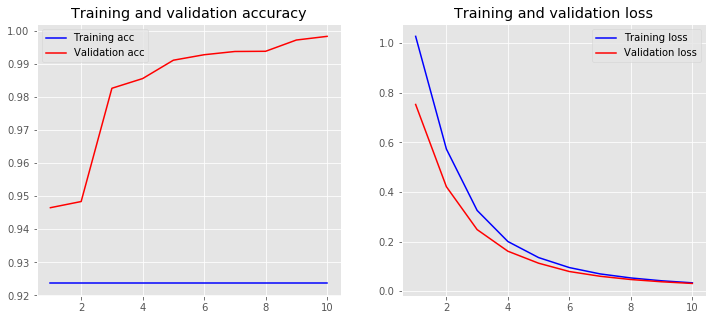

In [100]:
# Plot the graph 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)


In [115]:
idx2tag

{1: 'text', 2: 'object'}

In [119]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

In [120]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 87.5%


In [168]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      PAD       0.91      0.91      0.91      2729
     text       0.90      0.82      0.86      4248
   object       0.94      0.80      0.87      2117

micro avg       0.91      0.84      0.88      9094
macro avg       0.91      0.84      0.87      9094



In [121]:
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

              precision    recall  f1-score   support

         PAD       1.00      1.00      1.00    377237
      object       0.98      0.89      0.93      3662
        text       0.99      0.99      0.99     28451

    accuracy                           1.00    409350
   macro avg       0.99      0.96      0.97    409350
weighted avg       1.00      1.00      1.00    409350



In [129]:
tags.append("PAD")

['text', 'object', 'PAD']

In [144]:
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))

i=5
for w,true, pred in zip(X_test[i], test_labels[i] ,pred_labels[i]):
    if true != "PAD":
        print("{:15}: {:5} {}".format(words[w],true,pred))


Word           ||True ||Pred
29.01.2014     : text  text
-              : text  text
kaal           : text  text
68kg           : text  text
pikkus         : text  text
177,1cm        : text  text
KMI            : text  text
-              : text  text
21,68          : text  text
RR116/78mmHg   : object object
pulss          : text  text
80             : text  text
.              : text  text


In [133]:
test_sentence = " Tupp vaba, em.kael puhas, RR 155/85 mmhg , emakas vÃ¤ike, adn.ii."
test_sentence = ''.join(test_sentence).split() 

In [146]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=tag2idx["PAD"], truncating='post', maxlen=maxlen)


In [159]:
p = model.predict(x_test_sent)
p = pred2label(p)
# p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, pred))


Word           ||Prediction
Tupp           : text 
vaba,          : text 
em.kael        : text 
puhas,         : text 
RR             : object
155/85         : object
mmhg           : text 
,              : text 
emakas         : text 
vÃ¤ike,        : PAD  
adn.ii.        : PAD  
